# 🐶 Multi-class Dog Breed Classification.

This notebook builds a multi-class machine learning model that classifies dog breeds from image data using Tensorflow 2.0 and TensorFlow Hub.

I will use the following workflow.

<img src="https://drive.google.com/uc?export=view&id=147W_QMtNhsr4HRMIYWWr5quP7HNimD_B">

Since this is my first time working with TensorFlow, I will follow these steps in using TensorFlow. (I have not numbered these steps in the notebook.)

<img src="https://drive.google.com/uc?export=view&id=1IzZKjDz4cji2RQqcwopfVHX1DN4mj4DA">

## 1. Problem definition.

> Can you create an classifier capable of distinguishing between 120 dog breeds given an image of a dog?

## 2. Data.

The data used in this project is from [Kaggle's dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/).

## 3. Evaluation.

The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.

> Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

The [evaluation](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation) is a file with prediction probabilities for each dog breed of each test image.

## 4. Features.

* Images are unstructured data so we will train a deep learning/transfer learning model.

* There are 120 dog breeds (classes) that the machine learning model should be able to classify.

* There are 10,222 images in the training dataset and these have labels. We will also need to create two mutually exclusive sets from this so that we can have a training set and validations set.

* There are 10,357 images in the test dataset and these do not have labels.

In [1]:
# Unzipping the data I have uploaded into Google Drive.
# !unzip "/content/drive/My Drive/Kaggle/Dog Vision/dog-breed-identification.zip" -d "/content/drive/My Drive/Colab Notebooks/Dog Vision/"

### Getting the workspace ready.

* Import TensorFlow 2.$x$. ✅
* Import TensorFlow Hub. ✅
* Ensure a TensorFlow GPU is being used. ✅

In [2]:
# Import necessary tools into Colab
import tensorflow as tf
import tensorflow_hub as hub

# If you don't have TensorFlow 2:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Hub version: {hub.__version__}")

TensorFlow version: 2.2.0
TensorFlow Hub version: 0.8.0


In [3]:
# Check TensorFlow GPU availability.
def check_gpu_availability():
  print("There is a GPU available." if tf.config.list_physical_devices("GPU") else "There is not a GPU available.")

check_gpu_availability()

There is a GPU available.


### Getting the data ready.

Let's start by accessing the data and checking out the labels.

In [4]:
import pandas as pd

labels_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Dog Vision/labels.csv")
display(labels_csv.describe())
display(labels_csv.head())

id               breed
count                              10222               10222
unique                             10222                 120
top     755e33c45172fbee0a1dcddd453c1d0c  scottish_deerhound
freq                                   1                 126

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

[Google recommends](https://cloud.google.com/vision/automl/object-detection/docs/prepare), that for model training purposes, there should be at least 10 images per class when training image classification models. However it is desirable to have around 1000 images per label for better model performance.

The median number of photos per breed is 82.


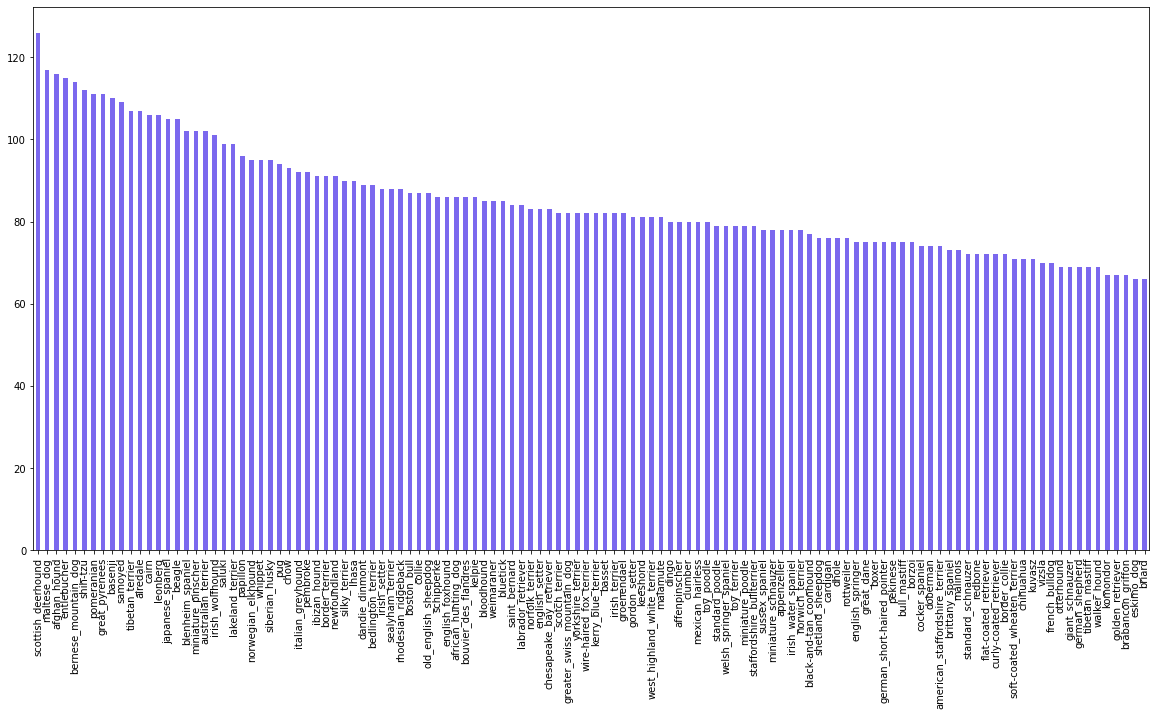

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10), color="mediumslateblue")
print(f"The median number of photos per breed is {int(labels_csv['breed'].value_counts().median())}.")

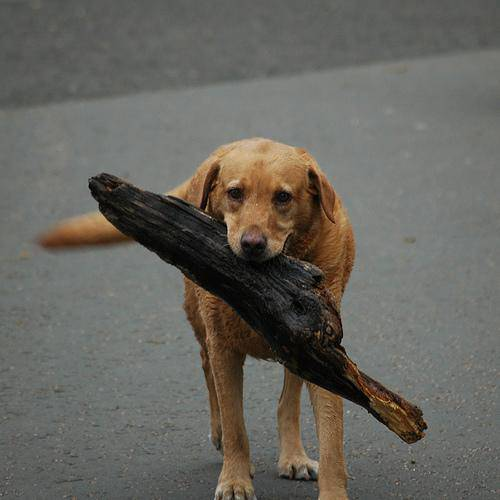

In [6]:
# Let's view an image.
from IPython.display import Image
Image("/content/drive/My Drive/Colab Notebooks/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

In [7]:
# Generate file paths for all training images by looping through image IDs in labels_csv.
filepaths = [f"/content/drive/My Drive/Colab Notebooks/Dog Vision/train/{id}.jpg" for id in labels_csv["id"]]

# Check the first 5 file paths.
filepaths[:5]

['/content/drive/My Drive/Colab Notebooks/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [8]:
import os

if len(os.listdir("/content/drive/My Drive/Colab Notebooks/Dog Vision/train")) == len(filepaths):
  print("Generated filepaths for all image IDs.")
else:
  print("Number of filepaths generated doesn't match the number of training data files.")

Generated filepaths for all image IDs.


Dog in image ID fff43b07992508bc822f33d8ffd902ae is of breed chesapeake_bay_retriever.


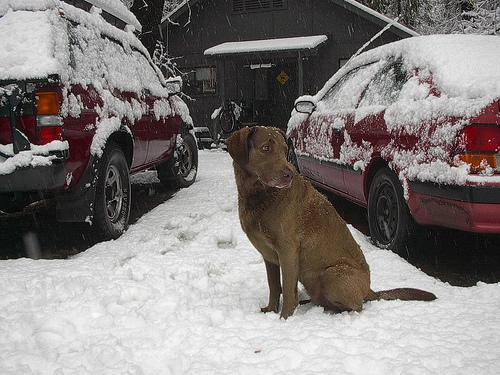

In [9]:
id = labels_csv["id"][10221]
breed = labels_csv["breed"][10221]
print(f"Dog in image ID {id} is of breed {breed}.")
Image(filepaths[10221])

In [10]:
import numpy as np

labels = np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [11]:
if len(labels) == len(filepaths):
  print("Number of labels matches number of filepaths.")
else:
  print("Number of labels does not match number of filepaths, check data directories.")

Number of labels matches number of filepaths.


In [12]:
# Get the unique breeds from labels. Should be 120.
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [13]:
# Turn every label into a boolean array identifying True at the index of the 
# unique breed array the dog for that label identifies with.
boolean_labels = [unique_breeds == label for label in labels]
print(f"Length of boolean array labels: {len(boolean_labels)}.\nLength of boolean array for each label: {len(boolean_labels[0])}.")
boolean_labels[:1]

Length of boolean array labels: 10222.
Length of boolean array for each label: 120.


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False])]

In [14]:
len(boolean_labels)

10222

In [15]:
# Turn boolean arrays into integer arrays.
print(labels[0])
print(np.where(unique_breeds == labels[0])) # Index where the label occurs in the unique_breeds array.
print(boolean_labels[0].argmax()) # Index where the label occurs in the boolean array.
print(boolean_labels[0].astype(int)) # True = 1 at the index.

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating the training and validation sets.

Kaggle only provided a training set so I will split this set into two mutually exclusive sets, one for training and one to use later for validation.

In [16]:
# Create X and y variables.
X = filepaths
y = boolean_labels

# Experimenting with ~1000 images for now.
NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10222, step: 100}

In [17]:
# Split the data into training and validation sets.
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], 
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [18]:
X_train[:2], y_train[:2]

(['/content/drive/My Drive/Colab Notebooks/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         

### Preprocessing the images into Tensors.

All machine learning models require the data to be in a numerical format. Images can be represented as NumPy arrays. These are suitable to convert into Tensors.

In [19]:
# Converting an image to a NumPy array by importing it using matplotlib.pyplot imread().
from matplotlib.pyplot import imread
image = imread(filepaths[42])
image.shape # (height, width, RGB)

(257, 350, 3)

In [20]:
# Convert the NumPy array into a Tensor.
tf.constant(image)[:2,:2]

<tf.Tensor: shape=(2, 2, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74]],

       [[ 72, 119,  73],
        [ 67, 114,  68]]], dtype=uint8)>

In [21]:
image[:2,:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74]],

       [[ 72, 119,  73],
        [ 67, 114,  68]]], dtype=uint8)

To turn the images into Tensors, we will implement a function for preprocessing.
1. Take the image file path as an input.
2. Use TensorFlow to read the file and save it to a variable, `image`.
3. Turn `image` (a `.jpg` file) into a Tensor.
4. Normalise the image's colour channel values (from 0-255 to 0-1).
5. Resize the image to be a standardised shape (we will use `(224, 224)`).
6. Return the modified `image`.

In [22]:
# Define square image size.
IMG_SIZE = 224

# Function that produces Tensors for an image using its filepath.
def process_image(image_path):
  """
  Returns a Tensor of the image provided at the file path image_path.
  """
  # Read in the image file using TensorFlow.
  image = tf.io.read_file(image_path)
  # Turn .jpg file into numerical jpeg Tensor with 3 colour channels, RGB.
  image = tf.image.decode_jpeg(image, channels=3)
  # Normalise the colour channel values (map the values from 0-255 scale to 0-1 scale).
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to the defined standard (IMG_SIZE, IMG_SIZE).
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [23]:
# TensorFlow reads in the file as binary string.
tensor = tf.io.read_file(filepaths[42])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\x01\x01^\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [24]:
tensor = tf.image.decode_jpeg(tensor, channels=3)
tensor[:2,:2]

<tf.Tensor: shape=(2, 2, 3), dtype=uint8, numpy=
array([[[ 88, 138,  87],
        [ 75, 125,  74]],

       [[ 71, 120,  73],
        [ 65, 115,  66]]], dtype=uint8)>

In [25]:
tensor = tf.image.convert_image_dtype(tensor, tf.float32)
tensor[:2,:2]

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[0.34509805, 0.5411765 , 0.34117648],
        [0.29411766, 0.4901961 , 0.2901961 ]],

       [[0.2784314 , 0.47058827, 0.28627452],
        [0.25490198, 0.45098042, 0.25882354]]], dtype=float32)>

### Turning the data into small batches.

We cannot process all the images simulatenously because the RAM available is limited. I will use a batch size of 32 images at a time (default).

To use TensorFlow effectively, the data needs to be in the form of Tensor tuples `(image, label)`.

In [26]:
# Function to return Tensor tuple (image, label).
def get_image_label(image_path, label):
  """
  Returns a tuple consisting of the Tensor processed from `image_path` and the 
  associated label.
  """
  return process_image(image_path), label

In [27]:
get_image_label(X[42], y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [28]:
# Define batch size.
BATCH_SIZE = 32

# Turn all data of X and y into batches using the preprocessing Tensor tuple function implemented.
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, set_type="test"):
  """
  Returns batches of Tensor tuples out of images X and labels y (if given).
  Shuffles the data if set_type="train" and does not shuffle if set_type="validation".
  Also accepts test data as input (no labels y given).
  """
  # If set given is training data, we want to shuffle it.
  if set_type is ("train" or None):
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling file paths before processing images (this is faster than the other way round).
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
      
  # If set given is validation data, we do not need to shuffle it.
  if set_type is "validation":
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Create (image, label) tuples, processes the image and batches them.
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  # If set given is test data, we won't have labels.
  if set_type is "test":
    print("Creating test data batches...")
    # Convert data into a Tensor Dataset.
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
    # Convert Tensor Dataset into batches.
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch
  
  print("Data has not been batched, pick an appropriate data set type")

In [29]:
# Creating the training and validation data batches
train_data_batches = create_data_batches(X_train, y_train, set_type="train")
val_data_batches = create_data_batches(X_val, y_val, set_type="validation")

Creating training data batches...
Creating validation data batches...


In [30]:
train_data_batches.element_spec, val_data_batches.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualising the data batches.

In [31]:
import matplotlib.pyplot as plt

# Function for viewing images in a data batch.
def show_25_images(images, labels):
  """
  Displays the first 25 images and corresponding labels from a data batch.
  """
  # Set up the figure.
  plt.figure(figsize=(10, 10))
  
  for i in range(25):
    # Create subplots (5 rows, 5 columns).
    ax = plt.subplot(5, 5, i + 1)
    # Display image and its label.
    plt.imshow(images[i])
    # Display the image title (breed) by finding the index of the max value (true) in its boolean label in labels.
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [32]:
train_data_batches

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

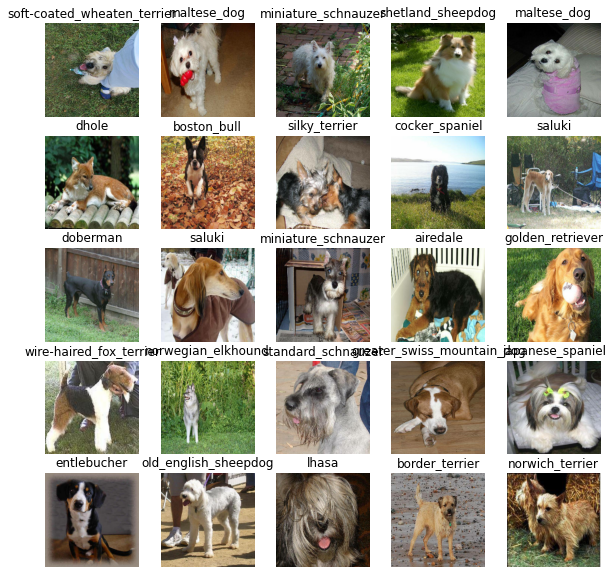

In [33]:
# We can iterate through train_data_batches using next() and as_numpy_iterator()
train_images, train_labels = next(train_data_batches.as_numpy_iterator())
len(train_images), len(train_labels)

# Visualising the training dataset.
show_25_images(train_images, train_labels)

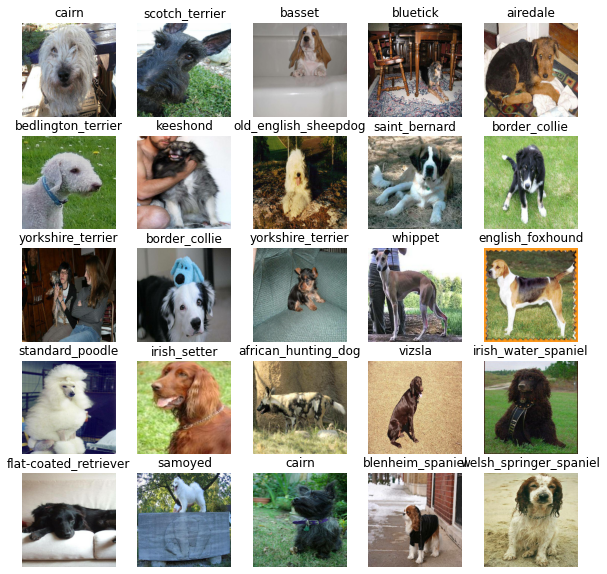

In [34]:
# Visualising the validation dataset.
val_images, val_labels = next(val_data_batches.as_numpy_iterator())
len(val_images), len(val_labels)
show_25_images(val_images, val_labels)

## 5. Modelling.

### Building a model.

Before building the model, we need to define:
* The input shape (the image shape in the form of a Tensor) to the model.
* The output shape (the image label in the form of a Tensor) of the model.
* The URL of the TensorFlow model to use from TensorFlow Hub.

In [35]:
# Set up the input shape to the model.
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, number of colour channels (RGB)

# Set up the output shape of the model.
OUTPUT_SHAPE = len(unique_breeds)

# Set up the model URL from TensorFlow Hub.
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

I will build and train the TensorFlow deep learning model using the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model).

I will create a function which:
* Takes the input shape, output shape and the model we are using as input parameters.
* Defines the layers in a Keras Sequential model.
* Compiles the model.
* Builds the model, given the input shape that will be used.
* Returns the model.

In [36]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print(f"Building model with: {model_url}")

  # Set up the model's layers.
  model = tf.keras.Sequential([
    # Layer 1: Input layer - Loads a presaved model as a Keras layer into the Keras model. 
    # MobileNet V2 uses an input shape of 224x224 RGB pixels (which is why we used this value 
    # as IMG_SIZE to reshape the images earlier)
    # https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c
    hub.KerasLayer(model_url),
    # Layer 2: Output layer - The output shape of the model (1x1x1280) doesn't match the 
    # output shape we need, so we need to create a Keras Dense layer to reshape the output.
    # https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c
    tf.keras.layers.Dense(units=output_shape,
                          activation="softmax"),
  ])

  # Compile the model.
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model.
  model.build(input_shape)

  return model

In [37]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating callbacks.

TensorFlow allows us to implement callbacks (helper functions) for models. Callbacks are used during training to do things such as saving or checking training progress or stop training early if a model stops improving.

#### [TensorBoard callback.](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)

The TensorBoard callback helps us trac the model's progress.

1. Load the TensorBoard notebook extension. ✅
2. Create a TensorBoard callback that is able to save logs to a directory and pass it to the model's `fit()` function.
3. Visualise the model's training logs with `%tensorboard` magic function after model training.

In [38]:
# Load TensorBoard notebook extension.
%load_ext tensorboard

In [39]:
import datetime

# Function that builds TensorBoard callback.
def create_tensorboard_callback():
  # Create a logs directory for storing TensorBoard logs.
  # Logs get tracked whenever an experiment is run so we use the current time to identify logs.
  logdir = os.path.join("/content/drive/My Drive/Colab Notebooks/Dog Vision/logs",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

#### [EarlyStopping callback.](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

Early stopping can stop the model from training for too long and prevent overfitting the data if a certain evaluation metric stops improving.

In [40]:
# EarlyStopping callback that will stop the model training when the validation accuracy stops improving within 3 patience epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

### Training the model on a subset of data.

The first model will only be trained on 1000 images to verify everything works before we start training on the whole dataset (which will take a lot longer).

In [41]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [42]:
check_gpu_availability()

There is a GPU available.


Now I can define a function that trains a model.
* Create a model using `create_model()`.
* Set up a TensorBoard callback using `create_tensorboard_callback()`.
* Call `fit()` on the model, passing it the training data, validation data, number of epochs to train for `NUM_EPOCHS` and the callbacks to use.
* Return the trained model.

In [43]:
# Function to train and return a trained model.
def train_model():
  """
  """
  # Create a model.
  model = create_model()

  # Create a new TensorBoard session for this model training instance.
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data and pass it the callbacks we are using.
  model.fit(x=train_data_batches,
            epochs=NUM_EPOCHS,
            validation_data=val_data_batches,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the trained model.
  return model

In [44]:
# Fit the model to the data.
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 261s 10s/step - loss: 4.5536 - accuracy: 0.1000 - val_loss: 3.4360 - val_accuracy: 0.2100
Epoch 2/100
25/25 [==============================] - 5s 183ms/step - loss: 1.6314 - accuracy: 0.6875 - val_loss: 2.2070 - val_accuracy: 0.4700
Epoch 3/100
25/25 [==============================] - 5s 182ms/step - loss: 0.5604 - accuracy: 0.9312 - val_loss: 1.6765 - val_accuracy: 0.5650
Epoch 4/100
25/25 [==============================] - 5s 180ms/step - loss: 0.2566 - accuracy: 0.9900 - val_loss: 1.5102 - val_accuracy: 0.6000
Epoch 5/100
25/25 [==============================] - 5s 182ms/step - loss: 0.1495 - accuracy: 0.9962 - val_loss: 1.4079 - val_accuracy: 0.6000
Epoch 6/100
25/25 [==============================] - 5s 182ms/step - loss: 0.1004 - accuracy: 0.9987 - val_loss: 1.3690 - val_accuracy: 0.6150
Epoch 7/100
25/25 [==============================

The ability to perform well on previously unobserved inputs is called generalisation.

It looks like the model is overfitting (i.e. not generalising well) since it is performing far better on the training dataset than the validation dataset. To prevent model overfitting in deep learning neural networks, we can:

* Use a larger model (increase the number of neural network layers) to reduce the generalisation error and increase the use of regularisation during training to keep the weights of the model nodes small. As well as reducing overfitting, this leads to faster model optimisation and better performance.

* Reduce overfitting by training the network on more examples.
  * The performance of a deep learning neural network get better when it is trained on more data.
  * When trained on a near-infinite number of samples, the capacity of what the model is capable of learning eventually plateaus. The reason models can overfit a smaller training dataset in the first place is because it has sufficient capacity to do so.
  * By reducing the capacity the model is capable of learning (by increasing the size of the dataset), the model is less likely to overfit the data to a point where it can no longer overfit.

* Reduce overfitting by constraining the model's complexity.
  * The complexity of a neural network model is defined by its structure in terms of nodes, layers and weight parameters. We can reduce the complexity of the neural network to reduce overfitting by:
    * **Structural stabilisation:** Changing the network structure (number of weight parameters).
      * We can do this by tuning the structure using grid search until an optimal combination of number of nodes and number of layers is found to reduce or remove overfitting.
      * Alternatively, we could remove nodes until the model achieves suitable performance on a validation set.
    * **Regularisation:** Change the network parameters (values of the weight parameters) by regularisation, which involves minimisation. Regularisation improves the generalisation error of a neural network model by tuning hyperparameters like weight decay coefficients. Minimising these weight parameters leads to a simpler model, as larger weights suggest a complex model that has overfit the data.
      * Constraining the complexity of the model via limiting the weight parameters to small values is a common method for reducing overfitting. Small parameters lead to a more stable model that is less sensitive to sharp statistical fluctuations in the input data and therefore reduces the model's effect on the outputs derived for the test data.
      * Common regularisation methods include:
        * [Weight decay](https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/): Penalise the model during training based on the magnitude of the weights to ensure these weights are minimised.
        * [Activity regularisation](https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/): Penalise the model during training based on the magnitude of activations i.e.
        * [Weight constraint](https://machinelearningmastery.com/introduction-to-weight-constraints-to-reduce-generalization-error-in-deep-learning/): Constrain the magnitude of the weights to be within a range.
        * [Dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/): Probabilistically (randomly) remove inputs during training.
        * [Noise](https://machinelearningmastery.com/train-neural-networks-with-noise-to-reduce-overfitting/): Add statistical noise to inputs during training to make the model more robust and able to generalise to new inputs well.
        * [Early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/): Monitor model performance on a validation set and stop training when performance plateaus/degrades.

**Always consider regularisation, unless you have a near infinite dateset like big data i.e. tens or hundreds of millions of datums.**


Source: https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/

### Checking the TensorBoard logs.

We can use the `%tensorboard` magic function to access the logs directory created earlier and visualise its contents.

In [45]:
%tensorboard --logdir "/content/drive/My Drive/Colab Notebooks/Dog Vision/logs"

<IPython.core.display.Javascript object>

## 6. Experimentation.

### Making and evaluation predictions using a trained model.

In [46]:
val_data_batches

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [47]:
# Make predictions on the validation data not used for taining.
predictions = model.predict(val_data_batches, verbose=1)
predictions

7/7 [==============================] - 1s 116ms/step


array([[5.6622992e-04, 6.1875954e-04, 3.8828037e-04, ..., 4.4492068e-04,
        1.9680852e-05, 4.9173869e-03],
       [5.8425423e-03, 2.5466392e-03, 2.7391810e-02, ..., 1.3860326e-03,
        3.4581802e-03, 1.5842557e-04],
       [1.3132867e-05, 4.8373447e-05, 6.4154078e-06, ..., 3.2372929e-05,
        8.0635564e-06, 8.4228610e-04],
       ...,
       [2.1482817e-06, 2.7136803e-05, 2.4161964e-04, ..., 7.7899102e-05,
        2.6978433e-04, 1.0052163e-05],
       [5.1584952e-03, 1.8484805e-04, 1.5984793e-04, ..., 6.2204876e-05,
        1.0410523e-04, 1.7943705e-02],
       [5.1247637e-04, 8.4463172e-06, 5.3807083e-03, ..., 7.0335256e-04,
        5.7518983e-04, 2.8876229e-05]], dtype=float32)

In [48]:
predictions.shape

(200, 120)

In [49]:
len(y_val), len(unique_breeds), len(predictions[0])

(200, 120, 120)

In [50]:
# This means that the maximum value in each image's prediction array is the most 
# probable class (dog breed) that could be identified from the image.
index = 0
print(predictions[index])
print(f"Sum of breed probabilities: {np.sum(predictions[index])}")
print(f"Max value (probability distribution of prediction: {np.max(predictions[index])}")
print(f"Max value occurs at index: {np.argmax(predictions[index])}")
print(f"Predicted dog breed: {unique_breeds[np.argmax(predictions[index])]}")

[5.66229923e-04 6.18759543e-04 3.88280372e-04 2.36720094e-04
 4.41585900e-04 8.22044749e-05 2.36991402e-02 1.66076294e-03
 1.00965997e-04 2.77486281e-04 1.31379045e-03 6.65802218e-05
 7.97822489e-04 1.06716827e-04 3.24487512e-04 2.53415143e-04
 8.98517246e-05 3.68114829e-01 8.56079805e-06 9.10516901e-05
 1.31318532e-03 1.90821142e-04 5.71606906e-05 1.11691130e-03
 1.21562654e-04 6.11133059e-04 1.90844446e-01 2.09424070e-05
 6.43209671e-04 1.27356412e-04 6.26257170e-05 6.37216819e-03
 1.24478142e-03 5.62224932e-06 8.14992018e-05 5.74961118e-03
 7.98377368e-06 3.94015544e-04 3.31948941e-05 1.93054278e-04
 9.07673675e-04 9.87956228e-05 6.89930966e-05 1.38417774e-04
 9.42983315e-05 3.19655046e-05 4.12557674e-05 2.53873994e-04
 1.66882202e-03 2.30519465e-04 1.04678897e-04 4.33610403e-05
 2.95922830e-04 4.62502940e-05 1.34399525e-05 1.03891020e-04
 7.32743720e-05 1.14031117e-02 9.42627725e-04 1.03160039e-01
 1.69691848e-04 2.80751556e-05 5.72933408e-04 2.03419513e-05
 3.15050449e-04 2.665070

It would be more useful to see the predictions along with the image the prediction was made on.

We should capture the above functionality into a function that performs the visualisation as well as displaying accuracies and probabilities.

In [51]:
# Turn the prediction probabilities into their respective labels.
def get_pred_label(y_probs):
  """
  Returns breed associated with the most probable class from the given prediction 
  probabilities array obtained from the model.
  """
  return unique_breeds[np.argmax(y_probs)]

# Get the predicted label based on the array of prediction probabilities.
pred_label = get_pred_label(predictions[0])

Since the validation data is still batched, we need to unbatch it to make predictions on all validation images and compare the predictions to the validation labels.

In [52]:
# Function that unbatches the data and separates the images and labels in order and returns them.
def unbatchify(data_batches):
  images = []
  labels = []
  for image, label in data_batches.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

val_images, val_labels = unbatchify(val_data_batches)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [53]:
get_pred_label(val_labels[0])

'affenpinscher'

In [54]:
get_pred_label(predictions[0])

'border_terrier'

Now we can get the:
* Predicted labels.
* Validation labels.
* Validation images.

We can now create functionality to visualise the correctness of the model's predictions.

I will create function that:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer `n` (representing sample `n` of the prediction probabilities). ✅
* Convert the prediction probabilites into the predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [55]:
def plot_pred(prediction_probabilities, labels, images, n=0):
  """
  Plots the predicted label, the true label and the image for the sample at index n.
  """
  y_probs, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the predicted label.
  pred_label = get_pred_label(y_probs)

  # Change colour of the title depending on whether prediction is correct
  colour = "green" if pred_label == true_label else "red"

  # Plot the image, remove ticks and set title to predicted label, probability of prediction and true label.
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(f"Predicted: {pred_label}\n" +
            f"Probability of classification: {np.max(y_probs) * 100 : 2.0f}%\n" +
            f"Actually: {true_label}",
            color=colour)
  pass


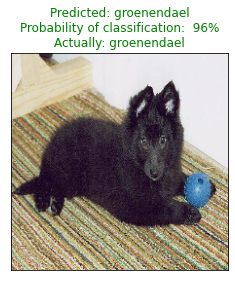

In [56]:
plot_pred(predictions, val_labels, val_images, n=77)

We will also implement a function that allows us to view the top 10 predictions the model could make for each image.

I will create a function that:
* Takes an array of prediction probabilities, an array of truth labels and an integer `n`(representing sample `n` of the prediction probabilities). ✅
* Finds the most confident prediction using `get_pred_label()`. ✅
* Outputs the top 10 prediction confidence':
  * Indexes. ✅
  * Values (probability of classification). ✅
  * Labels. ✅
* Plots the top 10 prediction probabilities using `plot_pred`. ✅

In [57]:
def plot_pred_conf(prediction_probabilities, labels, n=0):
  """
  Plots the top 10 highest prediction probabilities with its truth label for sample at index n.
  """
  y_probs, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label.
  pred_label = get_pred_label(y_probs)

  # Find the top 10 prediction confidence indices.
  # Find the order of indices that would sort y_probs (the probability of classifying each breed for image at sample n).
  # Take the top (last) 10 elements and reverse this list so we have the top 10 indices in descending order.
  top_10_pred_indices = y_probs.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values.
  top_10_pred_values = y_probs[top_10_pred_indices]

  # Find the labels/breeds for each of the top 10 predictions for image at sample n.
  top_10_pred_labels = unique_breeds[top_10_pred_indices]

  # Plot
  top_10_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                        top_10_pred_values,
                        color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation=90)
  if true_label in top_10_pred_labels:
    top_10_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

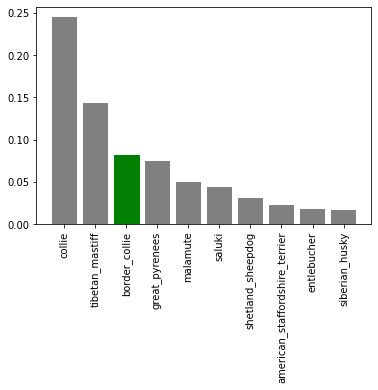

In [58]:
plot_pred_conf(predictions, val_labels, n=9)

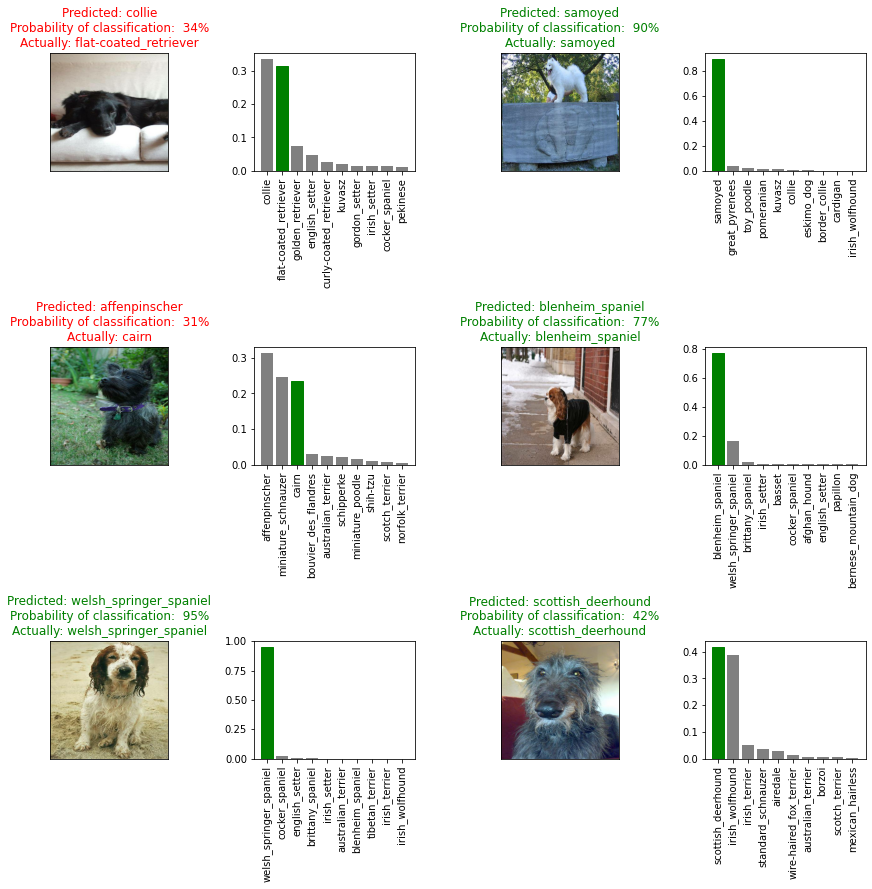

In [59]:
i_multiplier = 20
nrows = 3
ncols = 2
n_images = nrows * ncols

plt.figure(figsize=(5 * nrows, 5 * ncols))

for i in range(n_images):
  plt.subplot(nrows, 2 * ncols, 2 * i + 1)
  plot_pred(predictions,
            val_labels,
            val_images,
            n=i+i_multiplier)
  plt.subplot(nrows, 2 * ncols, 2 * i + 2)
  plot_pred_conf(predictions,
                 val_labels,
                 n=i+i_multiplier)

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
plt.show()

### COME BACK

**Challenge:** Create a confusion matrix displaying the model's predictions vs the true labels.

### Saving and reloading a trained model.

In [60]:
def save_model(model, suffix=None):
  """
  Saves the given model to the project's `models` directory with the suffix provided.
  """
  # Create the model directory's pathname using the current time.
  time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  modeldir = os.path.join(f"/content/drive/My Drive/Colab Notebooks/Dog Vision/models/{time}")
  
  # Create the model's pathname using the suffix and h5 extension (format to save TensorFlow models in).
  model_path = f"{modeldir}-{suffix}.h5"
  print(f"Saving model to {model_path}...")
  model.save(model_path)
  return model_path

In [61]:
def load_model(model_path):
  """
  Loads the trained model saved at model_path.
  """
  print(f"Loading model from {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     # Must define any custom objects used in model building. 
                                     # We used KerasLayer from TFHub so we must declare it.
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  model.summary()
  return model

In [62]:
# Saving the model trained on 1000 images.
path = save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to /content/drive/My Drive/Colab Notebooks/Dog Vision/models/20200730-112524-1000-images-mobilenetv2-Adam.h5...


In [63]:
# Loading the saved model.
loaded_1000_image_model = load_model(path)

Loading model from /content/drive/My Drive/Colab Notebooks/Dog Vision/models/20200730-112524-1000-images-mobilenetv2-Adam.h5...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  5432713   
_________________________________________________________________
dense_1 (Dense)              multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [64]:
# Evaluate the existing model.
model.evaluate(val_data_batches)

7/7 [==============================] - 1s 110ms/step - loss: 1.2748 - accuracy: 0.6200


[1.2747702598571777, 0.6200000047683716]

In [65]:
# Evaluate the newly loaded version of the same model.
loaded_1000_image_model.evaluate(val_data_batches)

7/7 [==============================] - 1s 127ms/step - loss: 1.2748 - accuracy: 0.6200


[1.2747702598571777, 0.6200000047683716]

### Training the model on the entire dataset.

In [66]:
len(X), len(y)

(10222, 10222)

In [67]:
X[:10]

['/content/drive/My Drive/Colab Notebooks/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [68]:
y[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [69]:
# Create training data batches using the full dataset.
full_data = create_data_batches(X, y, set_type="train")

Creating training data batches...


In [70]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [71]:
# Create a model that will be trained using the full dataset.
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [72]:
# Create full_model's callbacks
full_model_tensorboard = create_tensorboard_callback()
# We do not have a validation set since we are training the model using all the data.
# Therefore we cannot monitor validation accuracy, so we will need to use the EarlyStopping callback.
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** The cell below can take up to 30 minutes for the first epoch since the GPU has to load 10222 images into memory.

In [73]:
# Fit full_model to full_data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 4172s 13s/step - loss: 1.3407 - accuracy: 0.6734
Epoch 2/100
320/320 [==============================] - 51s 160ms/step - loss: 0.3955 - accuracy: 0.8822
Epoch 3/100
320/320 [==============================] - 50s 156ms/step - loss: 0.2395 - accuracy: 0.9329
Epoch 4/100
320/320 [==============================] - 49s 152ms/step - loss: 0.1516 - accuracy: 0.9635
Epoch 5/100
320/320 [==============================] - 49s 152ms/step - loss: 0.1072 - accuracy: 0.9776
Epoch 6/100
320/320 [==============================] - 48s 150ms/step - loss: 0.0775 - accuracy: 0.9872
Epoch 7/100
320/320 [==============================] - 47s 148ms/step - loss: 0.0588 - accuracy: 0.9923
Epoch 8/100
320/320 [==============================] - 47s 148ms/step - loss: 0.0454 - accuracy: 0.9944
Epoch 9/100
320/320 [==============================] - 48s 149ms/step - loss: 0.0366 - accuracy: 0.9958
Epoch 10/100
320/320 [==============================] - 47s 146m

In [74]:
full_model_path = save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")
full_model_path

Saving model to /content/drive/My Drive/Colab Notebooks/Dog Vision/models/20200730-124633-full-image-set-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Colab Notebooks/Dog Vision/models/20200730-124633-full-image-set-mobilenetv2-Adam.h5'

In [75]:
loaded_full_model = load_model(full_model_path)

Loading model from /content/drive/My Drive/Colab Notebooks/Dog Vision/models/20200730-124633-full-image-set-mobilenetv2-Adam.h5...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  5432713   
_________________________________________________________________
dense_2 (Dense)              multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## 7. Fulfilling the Kaggle requirement.

### Making predictions on the test dataset.

The model has been trained in the form of batches of Tensors so in order to make predictions on the test data provided, we need to also convert these into batches of Tensors.

To make predictions on the test dataset, I will:
1. Generate file paths for all test images. ✅
2. Convert the list of file paths into batches of Tensors using `create_data_batches()` defined earlier, with `set_type="test"` since the test data does not come with their true labels. ✅
3. Make predictions by passing the test data batches to the `predict()` method called on the model. ✅

In [76]:
# Generate file paths for all test images by looping through image IDs in labels_csv.
testdir = "/content/drive/My Drive/Colab Notebooks/Dog Vision/test/"
test_filepaths = [f"{testdir}{filepath}" for filepath in os.listdir(testdir)]
print(len(test_filepaths))
test_filepaths[:10]

10357


['/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f47cd43251c741ee459c688955c41f29.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f4ec1eb228bb0a7084de552fa4333b43.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f5b7603797d8a92d5b7b52d073891347.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f44005bd8019c5b9fb3ba2216e5d2af8.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f58ce44146db339a0bba50bcecb02730.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f58a21665136bb6aa4aa90c485be4315.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f4a3d9cf1909fb5d894ff5d5121af9b0.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f47e4614a5d7d190cf95b4b9c1e78576.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f5174e3ab52edb2e414e135259047c48.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Vision/test/f45014f665123584d3588802ee020bce.jpg']

In [77]:
# Create batches of Tensors from the test images file paths.
test_data_batches = create_data_batches(test_filepaths, set_type="test")

Creating test data batches...


**Note:** Calling `predict()` on the full model with all the test data (containing over 10,000 samples) will take ~1 hour to run.

In [78]:
# Make predictions on the test data using the full model.
test_predictions = loaded_full_model.predict(test_data_batches,
                                             verbose=1)

324/324 [==============================] - 5283s 16s/step


In [79]:
# Save these predictions (a NumPy array) into a CSV file so we don't have to run the above cell again.
np.savetxt("/content/drive/My Drive/Colab Notebooks/Dog Vision/predictions.csv", test_predictions, delimiter=",")

In [80]:
# Load predictions from the CSV file into a NumPy array.
test_predictions = np.loadtxt("/content/drive/My Drive/Colab Notebooks/Dog Vision/predictions.csv", delimiter=",")

In [81]:
test_predictions[:10]

array([[8.14563350e-08, 1.18476336e-07, 2.12201936e-08, ...,
        6.39421183e-09, 6.68322215e-08, 6.21975671e-09],
       [7.49021492e-05, 5.61597926e-06, 1.25152212e-07, ...,
        6.32734967e-08, 1.99918304e-05, 2.08128331e-04],
       [2.82011592e-09, 6.93364463e-11, 1.31677811e-11, ...,
        4.59568987e-08, 9.87349722e-06, 9.90269644e-09],
       ...,
       [1.65333459e-11, 7.12344672e-08, 8.30449043e-11, ...,
        2.97329592e-07, 1.57922710e-04, 4.08748484e-08],
       [1.88574326e-04, 8.08774026e-09, 1.42147599e-10, ...,
        1.41997814e-09, 6.22489305e-09, 9.21661580e-10],
       [8.85307818e-05, 2.19247177e-05, 2.71619979e-06, ...,
        9.76039446e-05, 1.29884097e-06, 1.98009231e-09]])

In [82]:
test_predictions.shape

(10357, 120)

### Preparing the test dataset predictions for [Kaggle submission](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation).



In [83]:
test_ids = [filepath[:-4] for filepath in os.listdir(testdir)]
df = pd.DataFrame(data=test_predictions, columns=unique_breeds)
df["id"] = test_ids
df = df[["id"] + [column for column in df.columns if column != "id"]]
df.shape

(10357, 121)

In [84]:
df.to_csv("/content/drive/My Drive/Colab Notebooks/Dog Vision/submission-mobilenetv2.csv",
          index=False)